In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv("./data/text_label.csv",  encoding='latin-1')

In [3]:
# Split into labeled and unlabeled data
labeled_data = df[df['LABEL'].notna()]
unlabeled_data = df[df['LABEL'].isna()]

# Split labeled data into train and validation sets
train_data, val_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

# Preprocess the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_data['FOI_TEXT'])
X_val = vectorizer.transform(val_data['FOI_TEXT'])
X_unlabeled = vectorizer.transform(unlabeled_data['FOI_TEXT'])

y_train = train_data['LABEL']
y_val = val_data['LABEL']

In [46]:
labeled_data['LABEL'].unique()

array([1., 4., 5., 2., 3.])

In [39]:
unlabeled_data['LABEL']

(9202,)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the classifier
clf = LogisticRegression(max_iter=1000)

# Train the classifier on labeled data
clf.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred = clf.predict(X_val)
initial_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}')


Validation Accuracy: 0.5185


In [29]:
data = pd.read_csv("./data/text_label.csv",  encoding='latin-1')
X = data['FOI_TEXT']  # Text data
y = data['LABEL']  # Labels

# Split into labeled and unlabeled
X_labeled = X[y.notnull()]
y_labeled = y[y.notnull()]
X_unlabeled = X[y.isnull()]

In [32]:
from sklearn.model_selection import train_test_split

# Split the labeled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features for efficiency
X_labeled_vec = vectorizer.fit_transform(X_labeled)
X_unlabeled_vec = vectorizer.transform(X_unlabeled)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [34]:
# Initialize the model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# Self-training loop
while True:
    # Fit the model on the training data
    model.fit(X_train_vec, y_train)

    # Get probability predictions on the unlabeled data
    y_pred_proba = model.predict_proba(X_unlabeled_vec)

    # Get indices of samples with high confidence predictions
    high_confidence_indices = np.where(np.max(y_pred_proba, axis=1) > 0.90)[0]

    if len(high_confidence_indices) == 0:
        break  # Exit if no high-confidence predictions

    # Get the corresponding text and predicted labels
    X_high_conf = X_unlabeled.iloc[high_confidence_indices]
    y_high_conf = np.argmax(y_pred_proba[high_confidence_indices], axis=1)

    # Append high-confidence samples to the labeled data
    X_train = pd.concat([X_train, X_high_conf])
    y_train = pd.concat([y_train, pd.Series(y_high_conf)])

    # Remove high-confidence samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_high_conf.index)

    # Re-vectorize the updated training data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_unlabeled_vec = vectorizer.transform(X_unlabeled)


In [35]:
# Evaluate on the test set
y_pred = model.predict(X_test_vec)

# Print classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90        44
         1.0       0.50      0.40      0.44        25
         2.0       0.47      0.47      0.47        15
         3.0       0.31      0.31      0.31        16
         4.0       0.83      0.38      0.53        13
         5.0       0.71      0.83      0.77        12

    accuracy                           0.65       125
   macro avg       0.61      0.57      0.57       125
weighted avg       0.64      0.65      0.63       125



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [48]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.65


In [3]:
from sklearn.preprocessing import LabelEncoder

# Split into labeled and unlabeled data
labeled_data = df[df['LABEL'].notna()]
unlabeled_data = df[df['LABEL'].isna()]

labeled_data["LABEL"] = labeled_data["LABEL"].astype(int)

label_encoder = LabelEncoder()
labeled_data['encoded_label'] = label_encoder.fit_transform(labeled_data['LABEL'])
# # Split labeled data into train and validation sets
# train_data, val_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

# # Preprocess the text data using TF-IDF
# vectorizer = TfidfVectorizer(max_features=10000)
# X_train = vectorizer.fit_transform(train_data['FOI_TEXT'])
# X_val = vectorizer.transform(val_data['FOI_TEXT'])
# X_unlabeled = vectorizer.transform(unlabeled_data['FOI_TEXT'])

# y_train = train_data['LABEL']
# y_val = val_data['LABEL']

/var/folders/xt/7gvkdnw143dgfgsp73bsn11w0000gn/T/ipykernel_1439/706233443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data["LABEL"] = labeled_data["LABEL"].astype(int)
/var/folders/xt/7gvkdnw143dgfgsp73bsn11w0000gn/T/ipykernel_1439/706233443.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['encoded_label'] = label_encoder.fit_transform(labeled_data['LABEL'])


In [4]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the BioBERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Tokenize labeled and unlabeled data
labeled_inputs = tokenize_texts(labeled_data['FOI_TEXT'].tolist())
unlabeled_inputs = tokenize_texts(unlabeled_data['FOI_TEXT'].tolist())


In [44]:
labeled_data['encoded_label'].unique()

array([0, 3, 4, 1, 2])

In [5]:
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments


# Load the BioBERT model for sequence classification
# model = BertForSequenceClassification.from_pretrained('dmis-lab/biobert-v1.1', num_labels=len(labeled_data['LABEL'].unique()))
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(labeled_data['LABEL'].unique()))

# Prepare labels
labels = torch.tensor(labeled_data['encoded_label'].tolist())


2024-10-06 13:09:47.388460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Create a dataset for the Trainer
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ensure we return a dictionary that matches the model's input format
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': self.labels[idx]  # Must be included as 'labels'
        }


# Create datasets
train_dataset = CustomDataset(labeled_inputs, labels)

In [7]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

  0%|          | 0/101 [00:00<?, ?it/s]

{'train_runtime': 801.1519, 'train_samples_per_second': 0.503, 'train_steps_per_second': 0.126, 'train_loss': 1.547321130733679, 'epoch': 1.0}


TrainOutput(global_step=101, training_loss=1.547321130733679, metrics={'train_runtime': 801.1519, 'train_samples_per_second': 0.503, 'train_steps_per_second': 0.126, 'total_flos': 53387217761280.0, 'train_loss': 1.547321130733679, 'epoch': 1.0})

In [8]:
# Define maximum iterations and confidence threshold
max_iterations = 5
confidence_threshold = 0.8
previous_pseudo_labels_count = 0

for iteration in range(max_iterations):
    print(f"Iteration {iteration + 1}/{max_iterations}")

    # Set model to evaluation mode
    model.eval()

    # Predict on unlabeled data
    with torch.no_grad():
        outputs = model(**unlabeled_inputs)
        predictions = torch.argmax(outputs.logits, dim=1)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)

    # Get high-confidence predictions
    high_confidence_indices = (probabilities.max(dim=1)[0] >= confidence_threshold).nonzero(as_tuple=True)[0]

    # Filter out high-confidence predictions
    pseudo_labels = predictions[high_confidence_indices]
    unlabeled_texts = unlabeled_data['text'].tolist()
    high_confidence_texts = [unlabeled_texts[i] for i in high_confidence_indices]

    # Create a new DataFrame for pseudo-labeled data
    pseudo_labeled_data = pd.DataFrame({
        'text': high_confidence_texts,
        'label': pseudo_labels.tolist()
    })

    # Stop if no new pseudo-labels are generated
    if len(pseudo_labeled_data) == 0:
        print("No high-confidence pseudo-labels found. Stopping the process.")
        break

    # Combine labeled and pseudo-labeled data
    combined_data = pd.concat([combined_data, pseudo_labeled_data], ignore_index=True)

    # Tokenize the combined dataset
    combined_inputs = tokenize_texts(combined_data['text'].tolist())
    combined_labels = torch.tensor(combined_data['label'].tolist())

    # Create dataset for Trainer
    combined_dataset = CustomDataset(combined_inputs, combined_labels)

    # Train the model again
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=combined_dataset,
    )

    trainer.train()

    # Optional: Check if the number of pseudo-labels is improving
    new_pseudo_labels_count = len(pseudo_labeled_data)
    if new_pseudo_labels_count == previous_pseudo_labels_count:
        print("No improvement in the number of pseudo-labels. Stopping the process.")
        break
    previous_pseudo_labels_count = new_pseudo_labels_count

# Final evaluation (optional)
trainer.evaluate()


Iteration 1/5


In [22]:
# Evaluation code (e.g., using metrics like accuracy, precision, recall)
trainer.evaluate()


NameError: name 'trainer' is not defined

In [ ]:
# Tokenize new data
new_data = ['new_unlabeled_text1', 'new_unlabeled_text2']
new_inputs = tokenize_texts(new_data)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**new_inputs)
    final_predictions = torch.argmax(outputs.logits, dim=1)

# Output predictions
print(final_predictions)


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. Load your dataset
# Assuming the DataFrame df has columns 'FOI_TEXT' (text data) and 'LABEL' (target labels)
# df = pd.read_csv('your_dataset.csv')
df = pd.read_csv("./data/text_label.csv",  encoding='latin-1')

# 2. Separate labeled and unlabeled data
labeled_data = df[df['LABEL'].notna()]
unlabeled_data = df[df['LABEL'].isna()]

# 3. Split the labeled data into training and validation sets
train_data, val_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

In [4]:
# 4. Preprocess the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)

X_train = vectorizer.fit_transform(train_data['FOI_TEXT']).toarray()  # Fit and transform on train data
X_val = vectorizer.transform(val_data['FOI_TEXT']).toarray()          # Transform only for validation data
X_unlabeled = vectorizer.transform(unlabeled_data['FOI_TEXT']).toarray()  # Transform for unlabeled data

# 5. Prepare labels for the semi-supervised model
y_train = y_train.fillna(-1)

# 6. Train the LabelPropagation model
label_prop_model = LabelPropagation(kernel='rbf', gamma=0.1)  # You can tune kernel and gamma
label_prop_model.fit(X_train, y_train)

# 7. Predict on the validation set to evaluate model performance
y_val_pred = label_prop_model.predict(X_val)

# 8. Evaluate the performance on the validation set
print("Accuracy on the validation set: ", accuracy_score(y_val, y_val_pred))
print("Classification report on validation set:\n", classification_report(y_val, y_val_pred))

Accuracy on the validation set:  0.3333333333333333
Classification report on validation set:
               precision    recall  f1-score   support

         1.0       0.33      1.00      0.50        27
         2.0       0.00      0.00      0.00        12
         3.0       0.00      0.00      0.00        21
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         9

    accuracy                           0.33        81
   macro avg       0.07      0.20      0.10        81
weighted avg       0.11      0.33      0.17        81



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

array([1., 1., 1., ..., 1., 1., 1.])

In [15]:
# 9. Predict labels for the unlabeled data
predicted_labels_unlabeled = label_prop_model.predict(X_unlabeled)

# 10. Add predicted labels to the unlabeled DataFrame
unlabeled_data['LABEL'] = predicted_labels_unlabeled

# 11. Combine the labeled and now-labeled data into one DataFrame
df_combined = pd.concat([labeled_data, unlabeled_data], axis=0)

# Check the results: View a sample of the data with predictions
print(df_combined[['FOI_TEXT', 'LABEL']].tail(20))

# Optionally, you can save the combined dataset
# df_combined.to_csv('combined_dataset_with_predictions.csv', index=False)

                                               FOI_TEXT  LABEL
9585  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...    1.0
9586  BLOCK A1: (B)(6). BLOCK D4, H4: THE COMPLAINAN...    1.0
9587  (B)(6). THE COMPLAINANT WAS UNABLE TO PROVIDE ...    1.0
9588  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...    1.0
9589  (B)(6). THE COMPLAINANT WAS UNABLE TO PROVIDE ...    1.0
9590  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...    1.0
9591  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...    1.0
9592  BLOCK A1: (B)(6). BLOCK D4, H4: THE COMPLAINAN...    1.0
9593  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...    1.0
9594  (B)(6). THE COMPLAINANT WAS UNABLE TO PROVIDE ...    1.0
9595  (B)(6). THE COMPLAINANT WAS UNABLE TO PROVIDE ...    1.0
9596  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...    1.0
9597  BLOCK A1: (B)(6). BLOCK D4, H4: THE COMPLAINAN...    1.0
9598  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...    1.0
9599  IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATI...

/var/folders/xt/7gvkdnw143dgfgsp73bsn11w0000gn/T/ipykernel_1404/215640336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['LABEL'] = predicted_labels_unlabeled


In [17]:
unlabeled_data[unlabeled_data['LABEL'] == 2]

,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,FOI_TEXT,DATE_RECEIVED,LABEL,predicted_label


In [20]:
np.unique(predicted_labels_unlabeled)

array([1.])

In [21]:
labeled_data['LABEL'].value_counts()

LABEL
1.0    126
3.0     78
2.0     75
4.0     66
5.0     58
Name: count, dtype: int64

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report
from transformers import pipeline


2024-10-06 20:26:56.910105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
unlabeled_data[:400].shape

(400, 7)

In [37]:
df = pd.read_csv("./data/text_label.csv",  encoding='latin-1')
labeled_data = df[df['LABEL'].notna()]
unlabeled_data = df[df['LABEL'].isna()][:40]

X_labeled = labeled_data['FOI_TEXT']
y_labeled = labeled_data['LABEL']
X_unlabeled = unlabeled_data['FOI_TEXT']

In [38]:
candidate_labels = [
    'Lowest severity',
    'Mild severity',
    'Moderate severity',
    'High severity',
    'Most severe'
]

In [25]:
# Step 1: Use Zero-Shot Classifier to label the unlabeled data
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [39]:
# Predict labels for the unlabeled data
from tqdm import tqdm

predictions = []
for text in tqdm(X_unlabeled, desc="Processing Unlabeled Data"):
    result = zero_shot_classifier(text, candidate_labels)
    predicted_label = result['labels'][0]  # Get the highest confidence label
    predictions.append(predicted_label)


Processing Unlabeled Data: 100%|██████████| 40/40 [03:48<00:00,  5.72s/it]


In [41]:
label_mapping = {
    'Lowest severity': 1,
    'Mild severity': 2,
    'Moderate severity': 3,
    'High severity': 4,
    'Most severe': 5
}

numeric_predictions = [label_mapping[label] for label in predictions]

In [47]:
labeled_data = labeled_data[['FOI_TEXT', 'LABEL']]

In [43]:
# Create a new DataFrame for predicted labels
predicted_df = pd.DataFrame({
    'FOI_TEXT': X_unlabeled,
    'LABEL': numeric_predictions
})


In [48]:
# Step 2: Combine the original labeled data with the new predicted data
combined_data = pd.concat([labeled_data, predicted_df], ignore_index=True)

In [50]:
# Prepare features for the combined dataset
X_combined = combined_data['FOI_TEXT']
y_combined = combined_data['LABEL']

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=10000)
X_combined_vec = vectorizer.fit_transform(X_combined)


In [51]:
# Step 3: Train a Classifier on the Combined Dataset
base_model = LogisticRegression(max_iter=1000)
self_training_model = SelfTrainingClassifier(base_model)

# Fit the self-training model on the combined dataset
self_training_model.fit(X_combined_vec, y_combined)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=1000))

In [52]:
# Step 4: Iterative Self-Training
num_iterations = 3  # Define the number of iterations
confidence_threshold = 0.7  # Set a confidence threshold for predictions

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}")

    # Predict labels for unlabeled data
    pseudo_labels = self_training_model.predict_proba(X_combined_vec)

    # Select high-confidence predictions
    high_confidence_indices = np.where(np.max(pseudo_labels, axis=1) >= confidence_threshold)[0]
    high_confidence_predictions = np.argmax(pseudo_labels, axis=1)[high_confidence_indices]

    # Create a DataFrame for high-confidence predictions
    high_confidence_df = pd.DataFrame({
        'FOI_TEXT': combined_data.iloc[high_confidence_indices]['FOI_TEXT'],
        'LABEL': high_confidence_predictions
    })

    # Combine the high-confidence predictions with the original labeled data
    combined_data = pd.concat([combined_data, high_confidence_df], ignore_index=True)

    # Vectorize the combined dataset again
    X_combined_vec = vectorizer.fit_transform(combined_data['FOI_TEXT'])
    y_combined = combined_data['LABEL']

    # Train the self-training model on the updated combined dataset
    self_training_model.fit(X_combined_vec, y_combined)

    # Optionally, evaluate the model on validation or test data
    y_combined_pred = self_training_model.predict(X_combined_vec)
    print(classification_report(y_combined, y_combined_pred))


Iteration 1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64        67
         1.0       0.66      0.52      0.58       126
         2.0       0.69      0.74      0.71        84
         3.0       0.74      0.63      0.68       107
         4.0       0.93      0.63      0.75        68
         5.0       0.78      0.90      0.83        58

    accuracy                           0.68       510
   macro avg       0.72      0.71      0.70       510
weighted avg       0.71      0.68      0.68       510

Iteration 2


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64        67
         1.0       0.66      0.52      0.58       126
         2.0       0.69      0.74      0.71        84
         3.0       0.74      0.63      0.68       107
         4.0       0.93      0.63      0.75        68
         5.0       0.78      0.90      0.83        58

    accuracy                           0.68       510
   macro avg       0.72      0.71      0.70       510
weighted avg       0.71      0.68      0.68       510

Iteration 3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64        67
         1.0       0.66      0.52      0.58       126
         2.0       0.69      0.74      0.71        84
         3.0       0.74      0.63      0.68       107
         4.0       0.93      0.63      0.75        68
         5.0       0.78      0.90      0.83        58

    accuracy                           0.68       510
   macro avg       0.72      0.71      0.70       510
weighted avg       0.71      0.68      0.68       510



In [53]:
# Final evaluation of the self-training model
y_final_pred = self_training_model.predict(X_combined_vec)
print("Final classification report:")
print(classification_report(y_combined, y_final_pred))


Final classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64        67
         1.0       0.66      0.52      0.58       126
         2.0       0.69      0.74      0.71        84
         3.0       0.74      0.63      0.68       107
         4.0       0.93      0.63      0.75        68
         5.0       0.78      0.90      0.83        58

    accuracy                           0.68       510
   macro avg       0.72      0.71      0.70       510
weighted avg       0.71      0.68      0.68       510



Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64        67
         1.0       0.66      0.52      0.58       126
         2.0       0.69      0.74      0.71        84
         3.0       0.74      0.63      0.68       107
         4.0       0.93      0.63      0.75        68
         5.0       0.78      0.90      0.83        58

    accuracy                           0.68       510
   macro avg       0.72      0.71      0.70       510
weighted avg       0.71      0.68      0.68       510



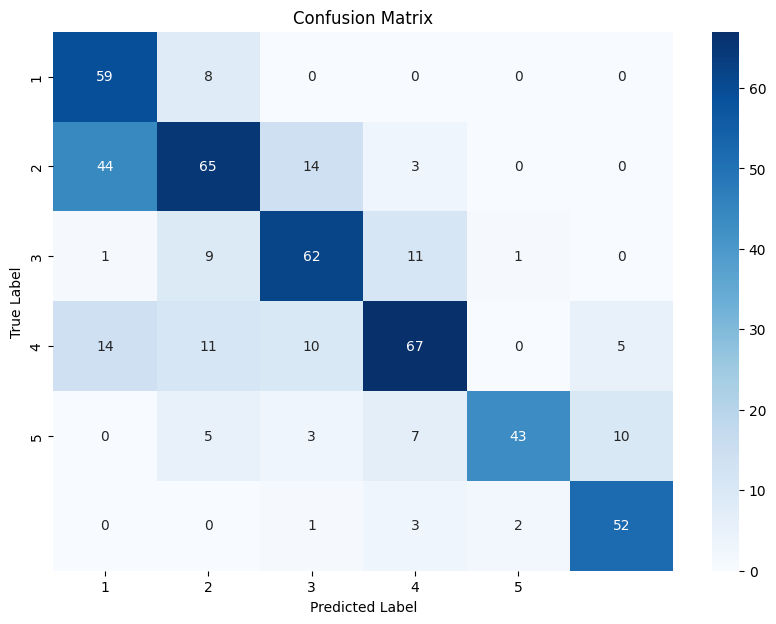

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_combined contains the true labels and y_final_pred contains the predicted labels
y_combined = combined_data['LABEL']  # True labels
y_final_pred = self_training_model.predict(X_combined_vec)  # Predicted labels

# Print the classification report
print("Classification Report:")
print(classification_report(y_combined, y_final_pred))

# Create and display the confusion matrix
cm = confusion_matrix(y_combined, y_final_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], 
            yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
